# Elastic search et word embedding

**Définition** : word embedding sur un ES en local => documents enrichi par le modèle sur ES

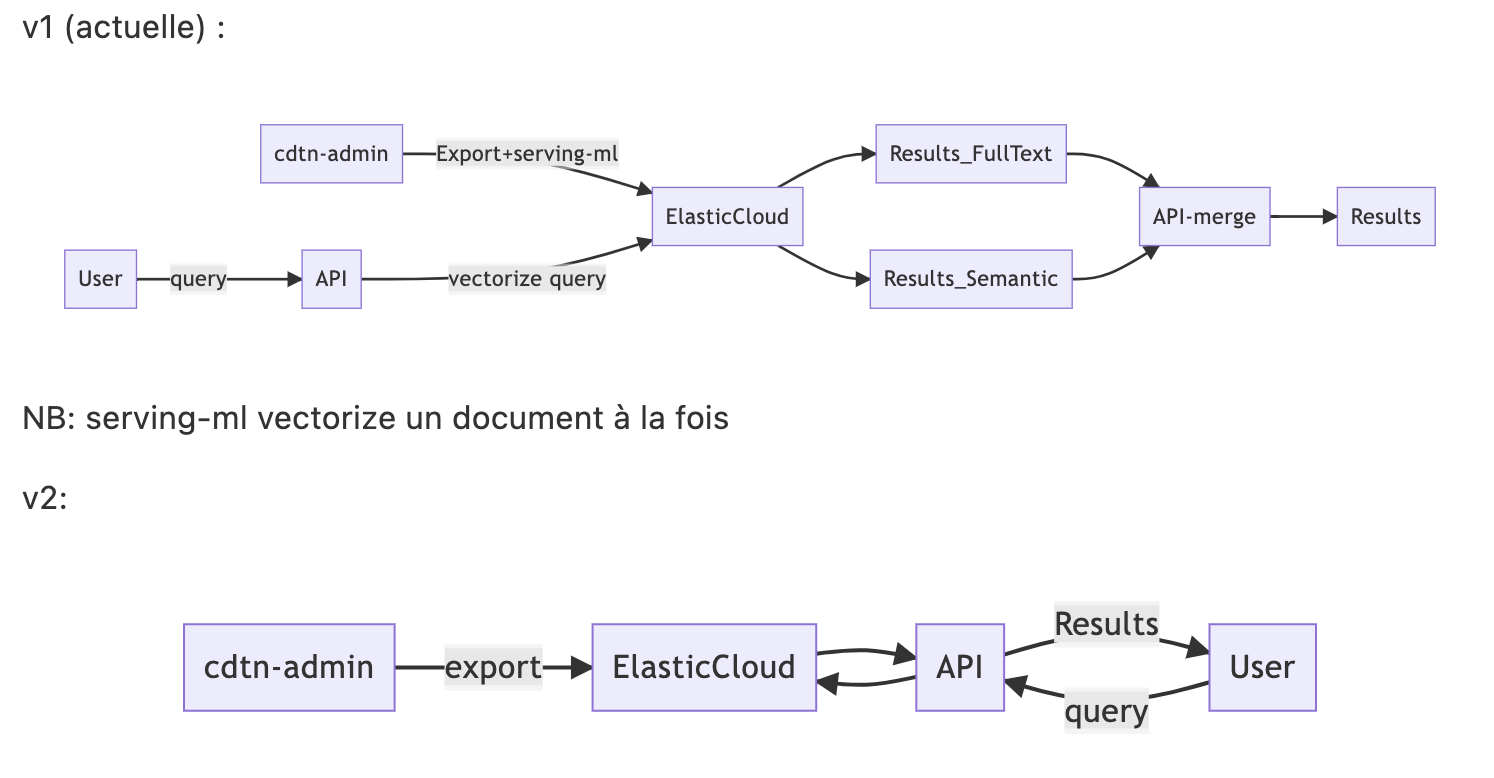

## Les imports

In [1]:
import pandas as pd
import numpy as np
import time
import json
import math
import os
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from typing import List, Dict
from ast import literal_eval

from elasticsearch import helpers, Elasticsearch

from src.elasticsearch_connector import ElasticsearchConnector

tqdm.pandas()
load_dotenv()

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 150)

# Lecture des données en provenance de l'elastic utilisé pour le moteur de recherche

Pour les quelques lignes de code suivante, il faut passer la version d'elasticsearch en 7.14 sinon on ne pourra pas se connecter à l'instance d'elastic

In [2]:
es_connector_admin = ElasticsearchConnector(env='admin')

connection with ElasticSearch is KO


In [3]:
query = { 'query': { 'match_all' : {} } }

documents = es_connector_admin.execute_query_json(query, 'cdtn-preprod-v2_documents-1662100956872')
len(documents)

  0%|          | 0/19166 [00:00<?, ?it/s]

19166

In [4]:
with open('data/documents.json', 'w', encoding='utf-8') as f:
    json.dump(documents, f, ensure_ascii=False, indent=4)

On peut repasser la version d'elasticsearch en version 8

In [3]:
with open('data/documents.json', 'r', encoding='utf-8') as f:
    documents_es = json.load(f)

In [4]:
documents_es[:5]

[{'_index': 'cdtn-preprod-v2_documents-1662100956872',
  '_type': '_doc',
  '_id': '1f38fda873',
  '_score': 1.0,
  '_source': {'date': '30/03/2022',
   'intro': '<p>Pour faire face à la forte hausse du coût des énergies, les salariés gagnant moins de <strong>2000 euros nets par mois</strong> (soit en pratique moins de 2600 euros bruts par mois) et ayant une rémunération brute inférieure à 26000 euros entre janvier et octobre 2021 vont percevoir l’indemnité inflation à partir du mois de décembre 2021 ou, au plus tard, le 28 février 2022.\nCette indemnité est une aide exceptionnelle et individuelle de <strong>100 euros</strong>. Elle est versée par l’employeur principal ou un organisme, qui en obtiendra par la suite le remboursement de l’État.\nLe versement de cette prime est réalisé de manière automatique si le salarié a travaillé plus de <strong>20 heures</strong> auprès d’un même employeur au mois d’octobre.</p>',
   'references': [{'label': 'Références juridiques',
     'links': [{'

In [5]:
df_documents_es = pd.read_csv('data/NLP/cdtn-documents.csv')

df_documents_es['title_vector'] = df_documents_es['title_vector'].apply(
    lambda x: literal_eval(x) if not pd.isnull(x) else []
)

/var/folders/n3/w_j4sm3n2sz1q7bqf_hh0twc0000gn/T/ipykernel_85329/1341379155.py:1: DtypeWarning: Columns (0,1,2,4,15,16,18,19,20,22,23,25,26,28,29,30,31,35,36,37,38,39,40,41,42,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df_documents_es = pd.read_csv('data/NLP/cdtn-documents.csv')


# Exporter les données déjà présentes dans l'elastic dans un elastic en 8.3 ou plus

## Ingérer les données dans Elastic Cloud

Et maintenant qu'on a trouvé un modèle (c'est pas encore le cas mais WIP) dans le notebook précédent [EXPLO_7_Elasticsearch_and_word_embedding](http://localhost:8888/notebooks/EXPLO_7_Elasticsearch_and_word_embedding.ipynb), on va pouvoir pousser les données dans elastic. 

Déclarons déjà les méthodes utilitaire pour elastic search :
- Création d'index
- Suppression d'index
- Dépot de données sur un index donnée

**NB: pour le moment on poussera les données avec les vecteurs en attendant d'avoir un modèle qu'on puisse pousser**

In [6]:
es_connector = ElasticsearchConnector(env='admin-test')

connection with ElasticSearch established with success


In [7]:
from elasticsearch import exceptions

def es_create_index_if_not_exists(es: Elasticsearch, index: str, mappings: Dict = None, settings: Dict = None):
    """Create the given ElasticSearch index and ignore error if it already exists"""
    try:
        #es.indices.create(index=index)
        if mappings == None:
            mappings = {
                "mappings": {
                    "properties": {  
                        "title": {
                            "type": "text"
                        },
                        "title_vector": {
                            "type": "dense_vector",
                            "dims": 512
                        },
                    }
                }
            }
        es.indices.create(index=index, mappings=mappings['mappings'], settings=settings['settings'])
    except exceptions.BadRequestError as ex:
        if ex.error == 'resource_already_exists_exception':
            print(f'Index {index} already exist')
        else: # Other exception - raise it
            raise ex


def es_delete_index_if_exists(es: Elasticsearch, index: str):
    """Delete the given ElasticSearch index and ignore error if it does not exists"""
    try:
        es.indices.delete(index=index)
    except exceptions.NotFoundError as ex:
        if ex.error == 'index_not_found_exception':
            pass # Index already exists. Ignore.
        else: # Other exception - raise it
            raise ex


def es_fill_index_with_json(es: Elasticsearch, index: str, documents: Dict):
    rows_to_insert = []
    
    for row in documents:
        if '_type' in row:
            del row['_type']
        row['_index'] = index
        rows_to_insert.append(row)
        
    helpers.bulk(es, rows_to_insert)
        

def es_fill_index_with_df(es: Elasticsearch, index: str, df: pd.DataFrame):
    #es.indices.delete(index=index, ignore=[400, 404])
    #es.indices.create(index=index, ignore=400)
    json_str = df.to_json(orient='records')
    json_records = json.loads(json_str)
    rows_to_insert = []
    
    for row in json_records:
        record = {
            '_op_type': 'index',
            '_index': index,
            #'_type' : '_doc',
            '_source': row
        }
        rows_to_insert.append(record)
        
    helpers.bulk(es, rows_to_insert)

In [8]:
with open('data/mappings_documents.json', 'r', encoding='utf-8') as f:
    mappings = json.load(f)
    
with open('data/settings_documents.json', 'r', encoding='utf-8') as f:
    settings = json.load(f)['documents_new']

In [9]:
index = 'documents_new'
# Example usage: Create "documents" index
es_create_index_if_not_exists(es_connector.connection, index, mappings, settings)

Index documents_new already exist


In [33]:
# Example usage: Dépot de données dans l'index
#index = documents_es[0]['_index']
es_fill_index_with_json(es_connector.connection, index, documents_es)

# Si on veut ajouter les documents qui ont été castés dans une DF vers un nouvel index :
#index = 'documents'
#es_fill_index_with_df(es_connector.connection, index, df_documents_es)

In [29]:
# Example usage: Supprimer l'index 
#es_delete_index_if_exists(es_connector.connection, index)

# Tuner la recherche pour obtenir les mêmes résultats que la recherche actuelle

https://www.elastic.co/guide/en/elasticsearch/reference/8.4/knn-search.html#_combine_approximate_knn_with_other_features

On va procéder en 3 étapes :
- Recherche full text classique
- Recherche sémantique '(vectorielle) classique
- Recherche en une seule requête combinant full text et sémantique

In [10]:
def filter_fields_in_source_dict_from_elasticsearch_response(document):
    fields = ['title', 'description', 'text', 'title_vector']
    document['_source'] = { field: document['_source'][field] if field in document['_source'] else '' for field in fields } 
    document['_source']['text'] = document['_source']['text'][:min(255, len(document['_source']['text']))]
    return document

def format_document(documents):
    [filter_fields_in_source_dict_from_elasticsearch_response(document) for document in documents]
    return documents

def format_response(response):
    return format_document(response['hits']['hits'])


## Recherche full text 

Commençons par le plus simple, la recherche full text.

In [11]:
# POST image-index/_search
query_full_text = {
  "query": {
    "match": {
      "title": {
        "query": "congés payés",
        "boost": 0.9
      }
    }
  },
  "size": 15
}

In [12]:
response_fulltext = format_response(es_connector.connection.search(
    index=index, query=query_full_text['query'], size=query_full_text['size']))

In [13]:
[doc['_source']['title'] for doc in response_fulltext]

['Congés payés',
 'Congés payés',
 'Les congés payés',
 'Les congés payés',
 'refus congés payés',
 'Les congés payés : qui a droit aux congés payés ?',
 'Réclamation de congés payés',
 'Les congés payés : à quel moment prendre les congés payés ?',
 'Indemnité compensatrice de congés payés',
 'Congés payés : nouveautés Covid-19',
 "Congés payés d'une assistante maternelle",
 'report congés payés et maladie',
 'indemnité compensatrice de congés payés',
 'Les congés payés : quelles sont les modalités de prise des congés payés ?',
 'Arrêt maladie et congés payés annuels']

Les résultats semblent cohérents 👌🏼

## Recherche sémantique

La recherche sémantique telle qu'elle est actuellement avec pour exemple, le query_vector de `congés payés`

In [14]:
query_vector_conge_payes = [0.0542744249,-0.000919510669,-0.0489541851,0.0188068971,-0.010789956,-0.0173273757,0.0252430681,0.000475855,-0.0122768115,-0.0652542263,0.0179819204,0.0575990528,-0.0141001157,0.0728688687,0.0196524188,-0.0601742566,0.0787327364,0.00394156668,-0.0196665,-0.0326176137,-0.0649307,-0.0455257855,0.0134797795,0.0229157284,0.00157343096,0.0280356109,-0.0609932542,0.00650982,-0.00037487704,-0.0145997843,0.0574885793,-0.0542049147,0.0011789673,0.00123542896,0.0561164804,0.011192509,0.00911963917,0.0660637319,-0.0180574767,0.0771964565,-0.0649635494,-0.0374231376,-0.00147044822,0.014297463,-0.0133998627,-0.0149444044,-0.00258636754,0.0423277579,-0.00152190682,-0.0301945265,-0.0375299305,0.0724680126,0.063042663,-0.000599501189,0.0476996787,0.0584852584,-0.0559378043,-0.0317377597,0.0152464081,-0.0497387536,-0.00173039525,-0.0446201488,-0.0371858105,0.0656061843,0.0387208,0.0518825725,-0.0363170803,-0.00916910823,0.0409041382,-0.0472324789,0.0643347427,0.0316624641,0.0811102092,-0.0723651722,-0.0667807162,0.0650793,0.0742550492,0.0498651527,-0.0586536527,-0.0819866955,0.0356698297,-0.0557813458,0.0727631077,-0.0190132819,0.0191921387,-0.0809999406,0.0315688066,0.00272888318,0.0629969,-0.0657720119,0.0542305,-0.0323459059,0.0730013624,0.0115729179,0.0269614719,-0.0614268258,-0.0198988635,0.0422379896,-0.0363509767,-0.00246022432,0.0427839048,0.040332634,-0.0494522788,0.0459901802,-0.0315314308,-0.0465080403,0.0438055247,-0.0309042856,0.0231311787,-0.0702314898,0.0419045538,0.0513530076,0.0403078198,0.0240960252,0.0641972423,-0.0385485552,0.0628498793,0.0599701218,-0.060613662,-0.0443366244,0.0202678069,0.0409009382,0.01722968,-0.0201027784,0.0342966579,-0.0312434956,-0.0293008536,-0.0798610076,-0.00834521092,0.0660892,0.0408957526,-0.0555241182,-0.0316419452,-0.020387914,-0.0157257263,-0.013023016,0.0488622934,-0.0360427648,0.0662326217,-0.0428311639,-0.00585581688,-0.0235316809,0.0365954377,-0.0692707896,-0.0690134764,0.0606840216,0.025186751,-0.0702988952,-0.0347267538,-0.0605745278,0.0122625325,0.0198514555,0.0388972498,-0.0138914445,-0.0321881622,0.0223663114,0.048342865,0.0411179774,-0.00854284596,-0.0403190479,0.0407026298,-0.0693960562,0.078522861,0.0673359782,0.0425909534,0.0123740258,0.000942004961,0.00637057,-0.0306553189,0.030392034,-0.0527276769,0.00739646377,-0.0683531538,0.024724694,0.0542985499,0.0267234445,-0.0021655797,-0.0750252,-0.015277748,0.00672641443,0.0601597577,-0.0507527888,-0.0252006855,-0.0566418096,-0.0361138955,0.0087461248,0.0271400791,-0.0089289723,-0.00760837086,0.0647544786,-0.0358579382,0.00247977884,0.0704668611,-0.021850571,-0.0277996156,0.00260861684,0.0042587514,0.012849031,0.0306400191,0.0486230366,0.0311204158,-0.000154082125,0.0697557628,0.0764967278,0.0492727607,0.0449156649,-0.0762014091,-0.0422531515,0.0499397106,-0.0026466304,0.0564387888,0.0379761979,-0.00289093377,-0.0392008349,-0.0343171768,-0.0565450378,0.00713269878,-0.0054364861,0.054657232,-0.00269317301,0.0545829795,-0.0302670281,0.0171369649,0.0524921566,0.040008802,-0.0475196689,0.0703153163,-0.00547523191,-0.0611670911,0.0628509298,-0.0490562394,0.0732844621,0.0494511314,-0.00805737264,-0.031874489,0.0459799021,0.0333438627,-0.0407773033,-0.0197306368,-0.0856356844,-0.0217892565,-0.0429807901,-0.0739691332,-0.00854289159,0.00810013432,-0.0418506488,0.0749355108,0.0157181676,-0.0561893359,-0.0807365701,0.0128534185,0.0665424615,0.0382805429,-0.000219124049,-0.00342976791,-0.072974734,0.0158419721,0.0211082343,0.0451306477,-0.0227178205,-0.0241839495,0.00583882583,0.0594897,-0.0249513593,-0.0708415285,-0.0256389845,-0.0176049154,-0.03683066,-0.00882478803,-0.0215042122,0.0228813924,-0.00212092604,-0.000654375064,-0.0445095301,-0.0568636432,-0.00585162779,-0.055026412,0.0570640787,0.0606587715,-0.00993181206,0.0619586296,0.0575070344,-0.0329488143,-0.027419094,0.0429415926,-0.0415909663,0.0158637725,-0.0809321254,-0.0160413086,0.0574569702,0.0660637692,0.0642250329,0.0170748197,-0.0398600809,0.0716102049,-0.0224829,0.0316633955,0.000889333256,-0.0339919627,0.0674602762,0.0156200882,-0.0123089757,0.00982039142,0.0391864516,-0.0445302054,-0.0679476783,0.0288746357,-0.0569767021,-0.0156993326,0.0237330925,-0.0752084479,-0.0278551895,0.0265107397,0.0724624768,0.0213369541,-0.0313779674,0.0489225686,-0.0519535169,-0.0447262526,-0.0319892503,-0.0601674616,-0.0491662845,0.0703925416,0.0445202515,-0.0557361878,0.06759426,0.00542459497,-0.0361926593,0.0242928583,0.0754698589,-0.014789653,0.063467674,-0.0441452414,-0.0276194438,-0.0481620021,0.0360924937,0.0713749304,-0.0696803853,0.0293369219,0.0128270397,-0.00331882085,-0.052375067,-0.0116770845,0.0572851598,-0.0364410616,0.0400225185,-0.0199316479,0.0507811941,-0.0242369585,0.0655807406,-0.0636979043,0.0234374925,0.00248647202,-0.0177295338,-0.0204105265,-0.0367692672,-0.0352589712,0.00835385639,0.0478877127,0.0149091072,0.0174906012,-0.0275018271,0.0221725,0.0734004304,0.00601103297,0.0694707632,0.00574133405,0.0592704341,-0.072820358,0.00495495228,-0.0788261,0.0196453705,0.00123251649,0.0387044,0.0149218496,-0.0379423127,0.0263789315,-0.0183139015,0.077583015,-0.054076653,0.0351789,-0.0477654822,0.0560891367,0.00705031119,-0.0197164435,-0.0237432346,-0.0270067398,-0.0774454549,0.0606968924,0.0728764832,-0.00438767299,0.037713062,0.00454427209,0.0665454,0.0637007505,0.0459651202,-0.0115399258,0.0322219208,0.0469518155,-0.0144772967,0.0507523157,-0.0235855207,-0.052176863,-0.0203045215,-0.0510925241,0.0725715384,-0.0160788968,0.0273453631,0.00226255413,-0.0370558947,-0.0419313796,-0.0442253351,-0.0276837535,-0.047936365,-0.0705361739,0.0637990162,-0.00192657602,0.0111146299,-0.0776060745,0.0592406243,-0.0110632209,0.0544788763,-0.0500230119,-0.0101844901,-0.0407116748,-0.0253123082,-0.0443295427,-0.0140384715,-0.06226255,-0.0648526,0.0338814259,0.0633387268,0.0710438192,0.0253423154,0.0317495205,-0.0221521482,0.0279687848,0.0293529723,0.00361695536,0.060157381,0.0332543217,-0.0685908273,0.0491260365,-0.000970811292,0.0665265769,0.0611919388,0.0479078926,-0.0402683429,-0.0288684405,-0.00857563317,0.00916005,0.0416359194,-0.0412005484,0.0413953289,0.0565764159,-0.0373282172,-0.00688861543,-0.00863195304,0.0422576293,-0.0586815663,0.00891981088,-0.0271429792,0.0072719031,0.0677283257,0.0578107908,0.0774825215,0.0115658352,0.0495276973,0.0541707203,-0.0682205632,-0.0172155648,0.0509518124,0.00644177105,0.0238002557,-0.0430593565,-0.0158296898,0.0268744919,0.0213339888,0.055395063,0.0271976031,-0.0389701054,-0.0349267572,0.0813603327,-0.0472052507,0.0478989631,0.023211468,-0.0525057726,0.0228577331,0.0360162221,0.016455194,0.0664690584,-0.0152239632,-0.0355249643,0.045810502,0.0674162954,-0.0690535605,-0.0762547627,0.0409660824,0.0776939169,0.0241731349,-0.0537101254,-0.0230662953,-0.0763657689,-0.028951291,0.059376996,0.0523412898,-0.0692002103,-0.0609500557,0.0256395675,-0.0130658494,0.00702967541,0.0077205631] 

In [15]:
query_semantique = {
  "query": {
    "script_score": {
      "query": {
        "bool": {
          "filter": [
            { "term": { "excludeFromSearch": False } },
            { "term": { "isPublished": True } },
            { "terms": { "source": ["fiches_ministere_travail", "fiches_service_public", "modeles_de_courriers", "outils", "contributions", "external", "dossiers", "information", "conventions_collectives"] } }
          ]
        }
      },
      "script": {
        "params": {
            "query_vector": query_vector_conge_payes
        },
        "source": "cosineSimilarity(params.query_vector, 'title_vector') + 1.0"
      }
    }
  },
  "size": 15
}

In [16]:
response_semantique = format_response(es_connector.connection.search(
    index=index, query=query_semantique['query'], size=query_semantique['size']))

In [17]:
[doc['_source']['title'] for doc in response_semantique]

['La prime de partage de la valeur [infographie]',
 "Négoce de l'ameublement",
 'Suivi médical des salariés [infographie]',
 'Suivi médical : report des visites [infographie]',
 'SIPSI',
 'Bâtiment ETAM',
 'Sidérurgie',
 'Ameublement (Fabrication)',
 'Indemnité de précarité',
 'Édition phonographique',
 "Sociétés d'assistance",
 'Édition',
 'Comment s’informer sur la VAE ?',
 'FNE-Formation',
 'Rupture conventionnelle pour les assisants maternels']

Maintenant avec la nouvelle implémentation et en recréant le mapping du `title_vector` ci-dessous :

``` json
"title_vector": {
    "type": "dense_vector",
    "dims": 512,
    "index": true,
    "similarity": "cosine"
}
```

In [18]:
query_semantique_new = {
  "knn": {
    "field": "title_vector",
    "query_vector": query_vector_conge_payes,
    "k": 15,
    "num_candidates": 50,
    "filter": [
      { "term": { "excludeFromSearch": False } },
      { "term": { "isPublished": True } },
      { "terms": { "source": [
          "fiches_ministere_travail", "fiches_service_public", "modeles_de_courriers", "outils", "contributions", 
          "external", "dossiers", "information", "conventions_collectives"] } }
    ],
    "boost": 0.5
  },
  "size": 15
}

In [19]:
response_semantique_new = format_response(es_connector.connection.search(
    index=index, knn=query_semantique_new['knn'], size=query_semantique_new['size']))

In [20]:
[doc['_source']['title'] for doc in response_semantique_new]

['La prime de partage de la valeur [infographie]',
 "Négoce de l'ameublement",
 'Suivi médical des salariés [infographie]',
 'Suivi médical : report des visites [infographie]',
 'SIPSI',
 'Bâtiment ETAM',
 'Sidérurgie',
 'Ameublement (Fabrication)',
 'Indemnité de précarité',
 'Édition phonographique',
 "Sociétés d'assistance",
 'Édition',
 'Comment s’informer sur la VAE ?',
 'FNE-Formation',
 'Rupture conventionnelle pour les assisants maternels']

On remarque que les résultats sont les mêmes et dans le même ordre.

On en déduit que le comportement n'est pas modifié pour la requête `congés payés`. Il faut répêter l'exercice sur un ensemble de requête.

## Recherche full text + sémantique en une requête

In [21]:
query = {
  "query": {
    "match": {
      "title": {
        "query": "congés payés",
        "boost": 0.9
      }
    }
  },
  "knn": {
    "field": "title_vector",
    "query_vector": query_vector_conge_payes,
    "k": 10,
    "num_candidates": 50,
    "filter": [
      { "term": { "excludeFromSearch": False } },
      { "term": { "isPublished": True } },
      { "terms": { "source": ["fiches_ministere_travail", "fiches_service_public", "modeles_de_courriers", "outils", "contributions", "external", "dossiers", "information", "conventions_collectives"] } }
    ],
    "boost": 0.1
  },
  "size": 25
}

In [22]:
response = format_response(es_connector.connection.search(
    index=index, 
    query=query['query'],
    knn=query['knn'],
    size=query['size'],
))

response

In [24]:
[doc['_source']['title'] for doc in response]

['Congés payés',
 'Congés payés',
 'Les congés payés',
 'Les congés payés',
 'refus congés payés',
 'Les congés payés : qui a droit aux congés payés ?',
 'Réclamation de congés payés',
 'Les congés payés : à quel moment prendre les congés payés ?',
 'Indemnité compensatrice de congés payés',
 'Congés payés : nouveautés Covid-19',
 "Congés payés d'une assistante maternelle",
 'report congés payés et maladie',
 'indemnité compensatrice de congés payés',
 'Les congés payés : quelles sont les modalités de prise des congés payés ?',
 'Arrêt maladie et congés payés annuels',
 'arrêt de travail et congés payés',
 'Les congés payés : quelles sont les conséquences de la maladie durant les congés payés ?',
 'Les congés payés : quelle est l’incidence de l’absence pour maladie sur le droit aux congés payés ?',
 'Les congés payés : comment calculer le nombre de jours de congés ?',
 "Comment calculer l'indemnité de congés payés du salarié ?",
 'Un salarié peut-il démissionner pendant ses congés payé

Les résultats semblent plutôt cohérents. Il ne reste plus qu'à comparer par rapport à l'attendu.